Outer ZIP extracted. Files: ['archive.zip']
Inner ZIP(s) found: ['extracted_outer\\archive.zip']
Inner ZIP extracted. Files: ['US_Accidents_March23.csv']
CSV file found: extracted_inner\US_Accidents_March23.csv
Dataset loaded successfully! Shape: (7728394, 46)


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


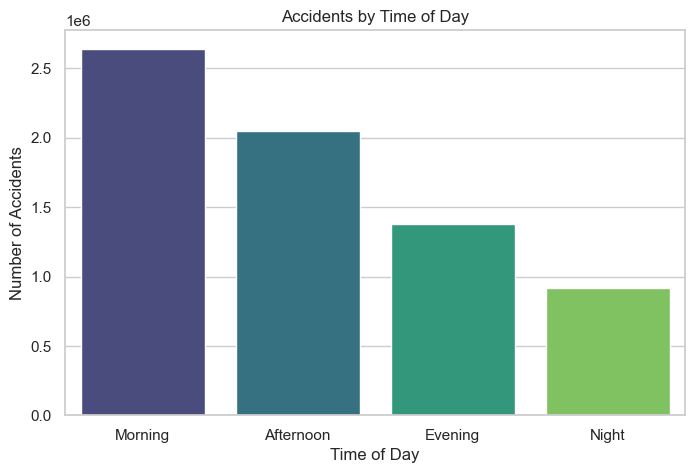

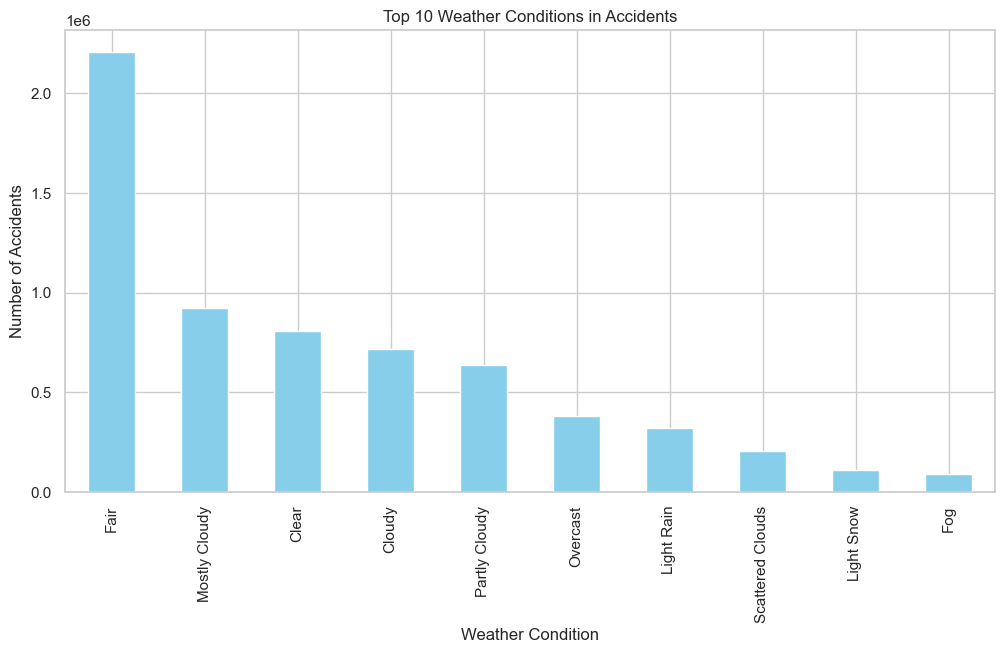

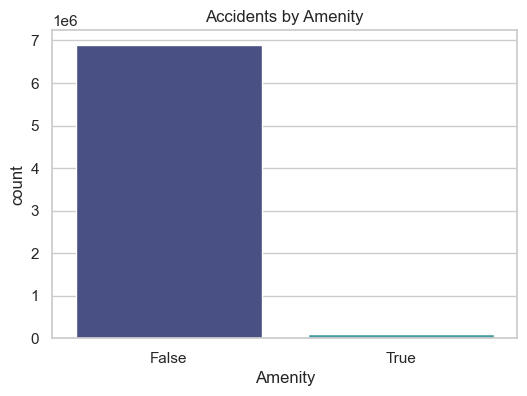

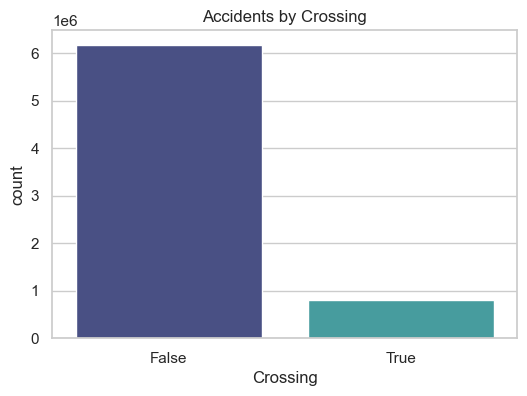

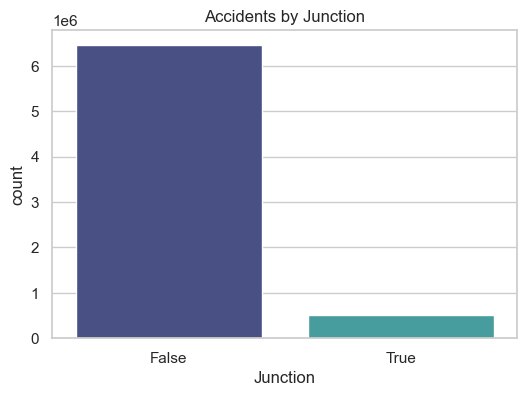

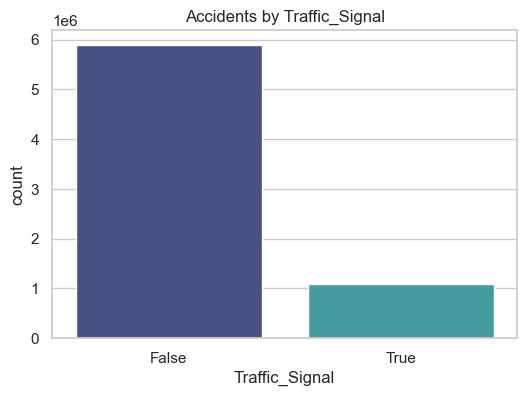

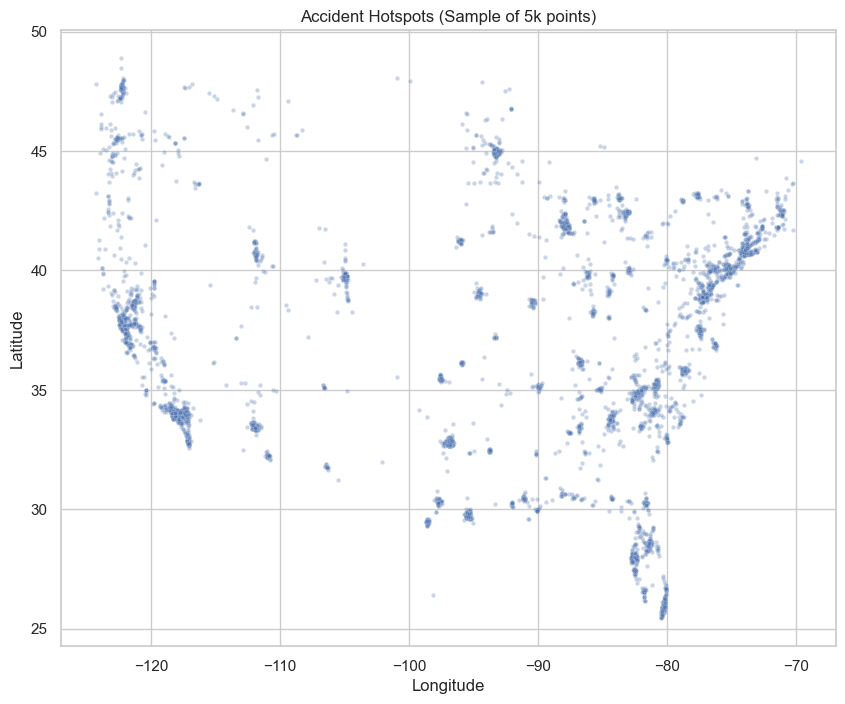

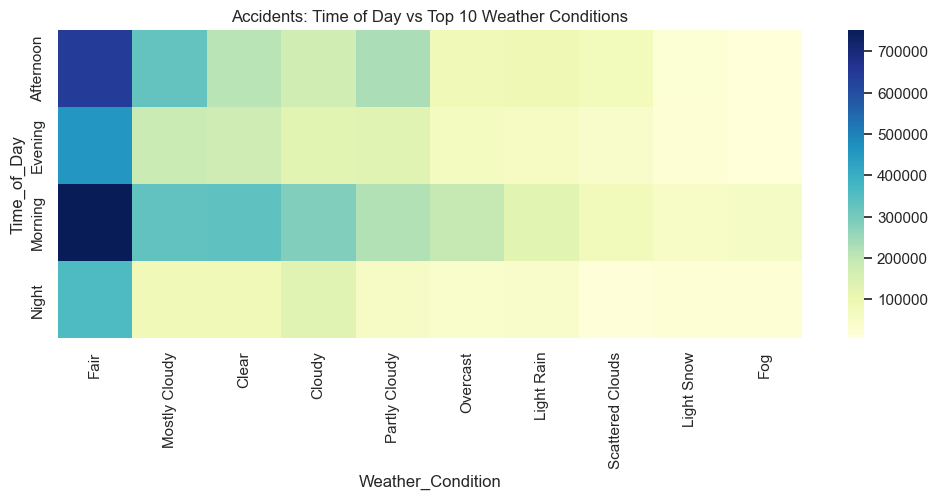

Accidents by Time of Day:
 Time_of_Day
Morning      2643097
Afternoon    2047528
Evening      1376175
Night         918428
Name: count, dtype: int64

Top 10 Weather Conditions:
 Weather_Condition
Fair                2206054
Mostly Cloudy        923515
Clear                808231
Cloudy               715030
Partly Cloudy        635456
Overcast             382802
Light Rain           322207
Scattered Clouds     204782
Light Snow           112300
Fog                   88488
Name: count, dtype: int64

Accidents by Amenity:
 Amenity
False    6897635
True       87593
Name: count, dtype: int64

Accidents by Crossing:
 Crossing
False    6177210
True      808018
Name: count, dtype: int64

Accidents by Junction:
 Junction
False    6464626
True      520602
Name: count, dtype: int64

Accidents by Traffic_Signal:
 Traffic_Signal
False    5897025
True     1088203
Name: count, dtype: int64


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

sns.set(style="whitegrid")


outer_zip = "Usaccidents.zip" 
extract_outer = "extracted_outer"
extract_inner = "extracted_inner"


os.makedirs(extract_outer, exist_ok=True)
with zipfile.ZipFile(outer_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_outer)
print("Outer ZIP extracted. Files:", os.listdir(extract_outer))


inner_zips = [os.path.join(extract_outer,f) for f in os.listdir(extract_outer) if f.endswith(".zip")]
if not inner_zips:
    raise FileNotFoundError("No inner ZIP found!")
print("Inner ZIP(s) found:", inner_zips)


os.makedirs(extract_inner, exist_ok=True)
with zipfile.ZipFile(inner_zips[0], 'r') as zip_ref:
    zip_ref.extractall(extract_inner)
print("Inner ZIP extracted. Files:", os.listdir(extract_inner))


csv_file = None
for root, dirs, files in os.walk(extract_inner):
    for file in files:
        if file.endswith(".csv"):
            csv_file = os.path.join(root, file)
            break
    if csv_file:
        break

if csv_file is None:
    raise FileNotFoundError("No CSV file found in extracted folders!")

print("CSV file found:", csv_file)


df = pd.read_csv(csv_file, low_memory=False)
print("Dataset loaded successfully! Shape:", df.shape)
display(df.head())


df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df = df.dropna(subset=['Start_Time','Start_Lat','Start_Lng'])


df['Hour'] = df['Start_Time'].dt.hour
df['Weekday'] = df['Start_Time'].dt.day_name()
df['Month'] = df['Start_Time'].dt.month

def time_of_day(hour):
    if 5 <= hour < 12: return 'Morning'
    elif 12 <= hour < 17: return 'Afternoon'
    elif 17 <= hour < 21: return 'Evening'
    else: return 'Night'

df['Time_of_Day'] = df['Hour'].apply(time_of_day)


plt.figure(figsize=(8,5))
sns.countplot(x='Time_of_Day', data=df, palette="viridis", order=['Morning','Afternoon','Evening','Night'])
plt.title("Accidents by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Accidents")
plt.show()


plt.figure(figsize=(12,6))
df['Weather_Condition'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Weather Conditions in Accidents")
plt.xlabel("Weather Condition")
plt.ylabel("Number of Accidents")
plt.show()


road_cols = ['Amenity','Crossing','Junction','Traffic_Signal']
available_cols = [col for col in road_cols if col in df.columns]

for col in available_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df, palette="mako")
    plt.title(f"Accidents by {col}")
    plt.show()


sample = df.sample(n=min(5000, len(df)), random_state=42)
plt.figure(figsize=(10,8))
sns.scatterplot(x='Start_Lng', y='Start_Lat', data=sample, alpha=0.3, s=10)
plt.title("Accident Hotspots (Sample of 5k points)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


pivot = pd.pivot_table(df, index='Time_of_Day', columns='Weather_Condition', values='ID', aggfunc='count', fill_value=0)
top_weather = pivot.sum().nlargest(10).index
pivot_top = pivot[top_weather]

plt.figure(figsize=(12,4))
sns.heatmap(pivot_top, cmap='YlGnBu', annot=False)
plt.title("Accidents: Time of Day vs Top 10 Weather Conditions")
plt.show()


time_summary = df['Time_of_Day'].value_counts()
weather_summary = df['Weather_Condition'].value_counts().head(10)
road_summary = {col: df[col].value_counts() for col in available_cols}

print("Accidents by Time of Day:\n", time_summary)
print("\nTop 10 Weather Conditions:\n", weather_summary)
for col, summary in road_summary.items():
    print(f"\nAccidents by {col}:\n", summary)
